# STAT 315 Final Project  
## Spotify Track Popularity Analysis  
**Group Members:** Ayushi Sharma, Bernardo Gonzalez Guerra, Mohnish Bandari  
**Course:** STAT 315 - Fall 2025

# 1. Research Questions

Our analysis focuses on the following questions:

1. What audio features are the strongest predictors of a song being popular on Spotify?
2. Can we accurately classify whether a song falls into a “high popularity” vs. “low popularity” group based solely on its audio features?
3. How well can we predict a song’s exact popularity score using a regression model, and which features contribute most to this prediction?
4. What correlations and relationships exist among audio features, and how might these influence model performance?
5. Do certain genres tend to have higher average popularity?
6. How much uncertainty exists in our predictions, as measured by cross-validation and bootstrap confidence intervals?

# 2. Data Collection

## Our dataset
For this project, we are using the Spotify Tracks Dataset from Kaggle, which contains over 230,000 songs pulled from Spotify’s Web API. Each row represents a single track, and the dataset includes a mixture of audio features, metadata, and Spotify’s own popularity score. The audio features (such as danceability, energy, and acousticness) are numerical values generated by Spotify’s signal processing models that describe different musical characteristics of each track. Because the dataset is large, mostly numeric, and relatively clean, it is well suited for exploratory data analysis and predictive modeling.

## Dataset Source
This dataset is publicly available on Kaggle at:
https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db

The original data was collected through Spotify’s Web API, which provides track level audio analysis values and popularity scores.

## Variable Descriptions
Below is a list of the key variables we will be using:
- genre: Genre label associated with the track.
- artist_name: Name of the performing artist.
- track_name: Name of the song.
- track_id: Unique Spotify ID for the track.
- popularity: Spotify-defined popularity score (0–100).
- acousticness: Confidence measure of whether a track is acoustic (0.0–1.0).
- danceability: How suitable a track is for dancing (0.0–1.0).
- duration_ms: Track duration in milliseconds.
- energy: Perceived intensity and activity of the track (0.0–1.0).
- instrumentalness: Likelihood the track contains no vocals (0.0–1.0).
- key: Musical key (0–11).
- liveness: Probability the track was performed live (0.0–1.0).
- loudness: Overall loudness of the track (in decibels).
- mode: Modal quality of the track (0 = minor, 1 = major).
- speechiness: Presence of spoken words in a track (0.0–1.0).
- tempo: Estimated tempo in beats per minute (BPM).
- time_signature: Estimated time signature (e.g., 3, 4, 5).
- valence: Musical “positiveness” conveyed by the track (0.0–1.0).

## Spotify Popularity Score
Spotify’s popularity metric ranges from 0 to 100, where higher values indicate a track that is streamed more often and more recently relative to others. The score is not based on audio features. Instead, it is derived from listener behavior such as stream counts, recency, playlist appearances, and user engagement. Because it reflects real-world streaming activity, this popularity score serves as a meaningful target variable for both regression and classification tasks.

## Load Spotify Dataset

In [111]:
# Load data
import pandas as pd
import numpy as np

df = pd.read_csv('../data/SpotifyFeatures.csv')

df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


### Dataset Summary

The dataset contains **232,725 rows** and **18 columns**. Most of the variables are numeric 
features such as danceability, energy, valence, loudness, tempo, and other audio related 
attributes generated by Spotify's API. A few variables, such as `track_name`, `artist_name`, 
and `genre`, are stored as object/string types.

Numeric columns include float based audio features (danceability, energy, valence, acousticness, 
speechiness, instrumentalness, etc) as well as integer based metadata (popularity, key, 
time_signature). The object columns contain track metadata.

# 3. Data Cleaning & Preparation

This section ensures the dataset is complete, consistent, and ready for modeling. We check for missing values, remove duplicates, engineer new features, and prepare the final feature set used in regression and classification models.


In [112]:
# Check missing values
df.isna().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

### Missing Values Summary

The missing values check shows that the dataset is almost completely full, with only 
one missing value found in the `track_name` column. Since every other column has zero 
missing entries and the dataset contains over 232,000 rows, removing this single row 
is the simplest and most appropriate approach. This ensures data consistency without 
any meaningful loss of information.


In [113]:
# Drop rows with missing values
df = df.dropna()
df.shape

(232725, 18)

After removing the single row containing a missing value, the dataset remains large 
and complete. This prepares the data for further preprocessing and analysis.

In [114]:
# check for and remove duplicates
df = df.drop_duplicates()
df.shape


(232725, 18)

### Duplicate Check

We checked for duplicate rows using `df.drop_duplicates()`. The shape of the dataset 
remained the same before and after this operation, indicating that there were no 
duplicate tracks present. This means the dataset is already clean with respect to 
duplicated entries.


## Creating New Features

### 1. Converting duration from milliseconds to minutes:
We convert track duration from milliseconds to minutes for better interpretability 
in visualizations and modeling.


In [115]:
df['duration_min'] = df['duration_ms'] / 60000


### 2. Create “high_popularity” variable:
To create a balanced classification target, we define a track as "high popularity" if 
its popularity score is above the median of the dataset. This ensures an approximately 
50/50 split between high and low popularity classes. We use the median threshold, which is best for balanced classes.


In [116]:
threshold = df['popularity'].median()
df['high_popularity'] = (df['popularity'] >= threshold).astype(int)
threshold


43.0

We find that the median popularity is 43.0. So, we define high popularity as popularity >= 43 and low popularity as popularity < 43.

## Selecting Features for Modeling

In [117]:
features = [
    'danceability', 'energy', 'valence', 'loudness', 'tempo',
    'acousticness', 'instrumentalness', 'speechiness', 'liveness',
    'duration_min'
]

X = df[features]
y_reg = df['popularity']
y_clf = df['high_popularity']


We define our feature matrix `X` using key audio characteristics that are numeric 
and suitable for regression and classification. Our regression target is the continuous 
popularity score, and our classification target is the binary high_popularity variable.


# 4. Exploratory Data Analysis (EDA)

Before building predictive models, in this section we explore the structure of the dataset and examine how Spotify audio features relate to popularity. This includes:

- distribution plots  
- correlation heatmaps  
- scatterplots  
- high vs low popularity comparisons  
- genre-level differences  

These exploratory analyses will help us anticipate model performance and understand the relationships among the features.


## Correlation Heatmap
The correlation heatmap helps identify which audio features are most closely associated with popularity.


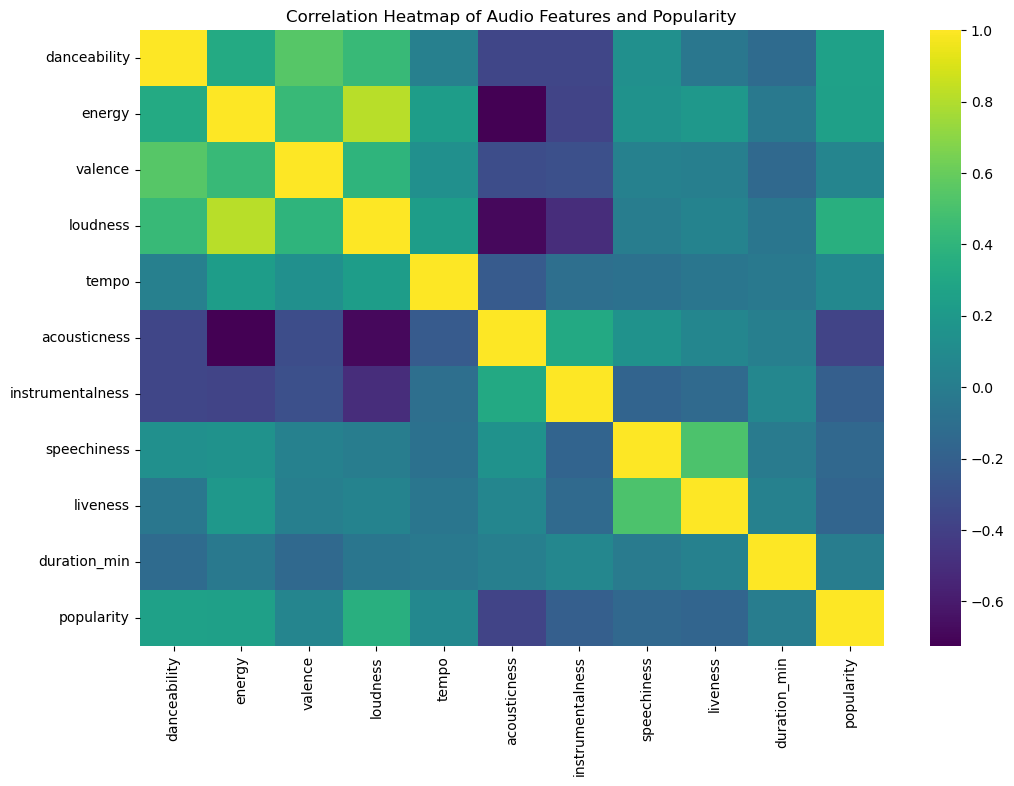

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df[features + ['popularity']].corr(), cmap='viridis', annot=False)
plt.title('Correlation Heatmap of Audio Features and Popularity')
plt.show()


### Interpretation of Correlation Heatmap

The correlation heatmap provides an overview of how Spotify’s audio features relate both to one another and to a track’s popularity score. The most important takeaway is that popularity has only weak linear relationships with any individual audio feature. Features such as loudness, energy, danceability, and valence show small positive correlations with popularity, but the magnitudes are low, indicating that these characteristics only modestly influence how popular a song becomes. Similarly, acousticness shows a moderate negative correlation with popularity, meaning that highly acoustic tracks tend to be less popular on average. Overall, the heatmap suggests that popularity is not strongly determined by musical attributes alone, which aligns with Spotify’s metric being heavily driven by user behavior, recency, and playlist exposure rather than audio characteristics.

A more noticeable pattern appears in the relationships among the audio features themselves. Certain features, particularly energy and loudness, are very strongly correlated, reflecting that they capture similar underlying musical intensity. Acousticness also shows a strong negative correlation with both energy and loudness, consistent with the contrast between quiet, acoustic tracks and louder, high intensity songs. Meanwhile, other features such as tempo, liveness, speechiness, and duration show almost no correlation with popularity and only weak relationships with other features. These internal feature relationships have important implications for modeling, because clusters of highly correlated predictors can introduce multicollinearity, making it harder for linear regression to isolate the effect of any single feature.

In the context of our research questions, this heatmap offers early evidence for several conclusions.
For Question 1, the correlations indicate that although some features (like loudness or energy) relate to popularity, none serve as strong predictors, which foreshadows the modest performance we later observe in regression and classification models.
For Question 4, the heatmap directly answers the question about relationships among audio features by revealing meaningful structure, such as the strong loudness, energy connection and the acousticness–energy contrast.
Finally, the weak correlations between predictors and popularity help explain the results in Question 2 and Question 3, where both logistic and linear models struggle to achieve high predictive accuracy.

Overall, the correlation heatmap establishes an important foundation for the rest of the analysis, which is that popularity is only weakly tied to musical attributes, and audio features themselves are often highly interrelated, both of which shape how effective our statistical models can be.

## Popularity Distribution
Popularity scores range from 0–100, with many tracks clustered at lower values. 
This indicates that most songs on Spotify are relatively less popular, and only 
a smaller subset achieves high popularity.



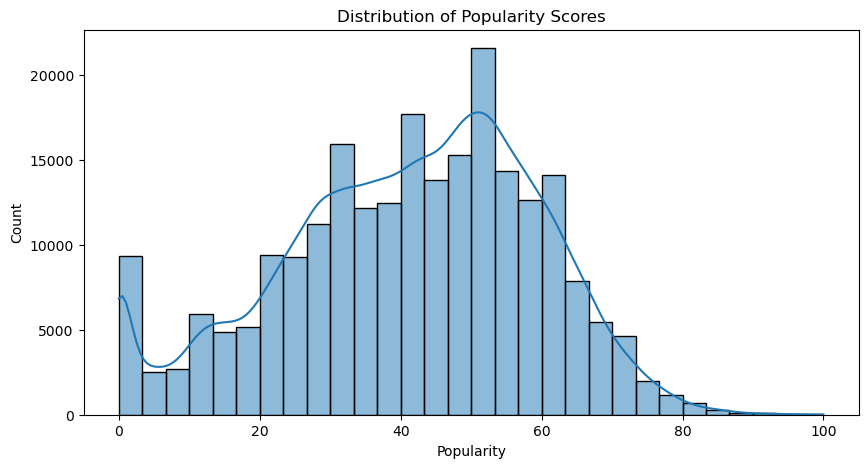

In [119]:
plt.figure(figsize=(10, 5))
sns.histplot(df['popularity'], kde=True, bins=30)
plt.title("Distribution of Popularity Scores")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()


### Interpretation of Popularity Distribution

The distribution of Spotify popularity scores reveals that popularity is not evenly spread across songs, and instead follows a moderately right skewed pattern. The histogram shows a large concentration of tracks with popularity values between roughly 20 and 60, with the highest density near the 40 to 55 range, indicating that most tracks in the dataset achieve only moderate recognition on the platform. At the same time, there is a clear long tail stretching toward higher popularity values, showing that only a small fraction of songs reach very high popularity (above 70 or 80), and extremely popular tracks (90+) are rare. The left side of the distribution also contains a noticeable spike near zero, reflecting the large number of tracks that have almost no recent streams or listener engagement. Taken together, this pattern suggests that Spotify’s catalog is dominated by mid-tier and low-engagement songs, with only a select minority achieving widespread success.

This distribution has important implications for our analysis and directly supports several of our research questions. For Question 2 (classification), the shape of the distribution justifies using the median popularity score as the threshold for defining “high” vs “low” popularity, because the distribution is not symmetric and we want balanced classes. For Question 3 (regression modeling), the spread of the histogram visually explains why predicting an exact popularity score is challenging, since the wide dispersion and heavy right tail indicate substantial inherent variability that audio features alone may not capture. Additionally, the skewness suggests that regression residuals may not follow perfect normality, which is important to acknowledge when assessing model assumptions.

More broadly, this distribution reinforces that popularity behaves like a behavioral metric, and not one that is just dependent on musical attributes. The uneven, right skewed shape reflects the influence of external factors such as playlisting, fanbase size, marketing, and release timing. Understanding this distribution sets realistic expectations for the predictive power of our models and provides important context for interpreting both linear regression and logistic regression results.

## Audio Feature Distribution
These distributions show how Spotify's audio attributes vary across tracks. Some features follow more uniform distributions, while others show heavy skewness.


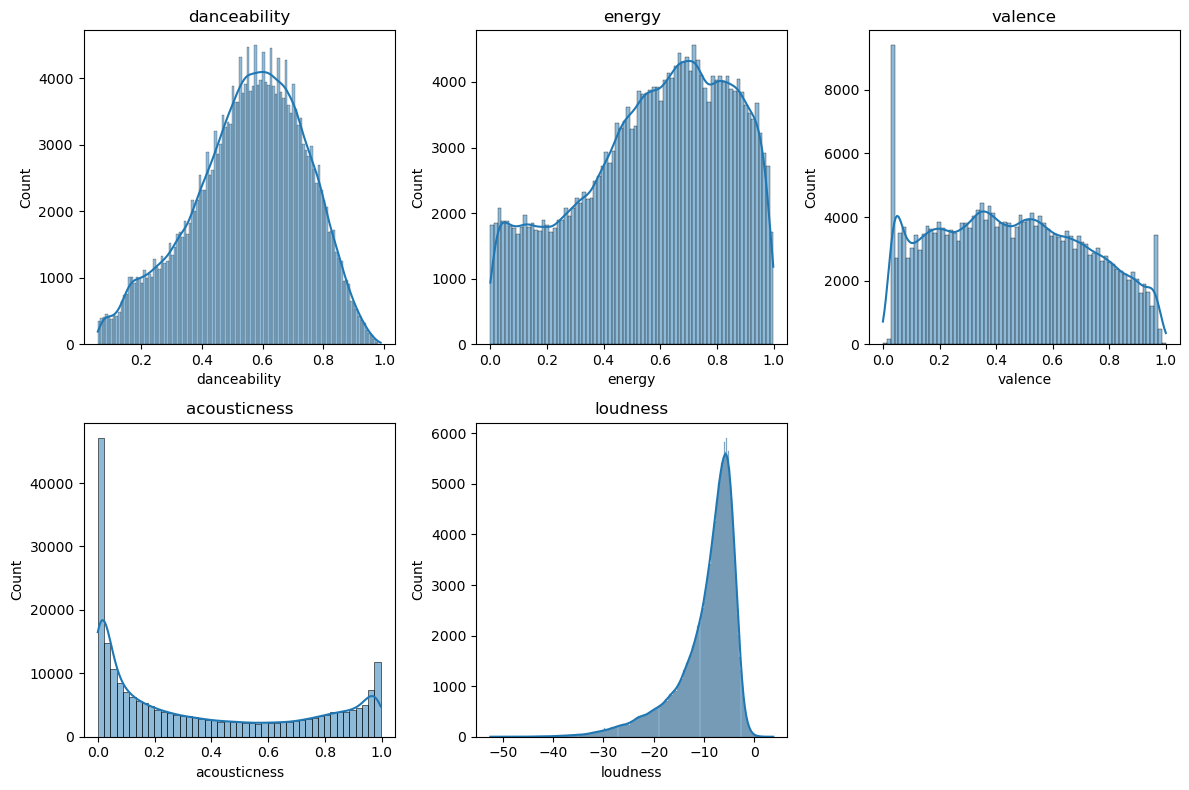

In [120]:
cols_to_plot = ['danceability', 'energy', 'valence', 'acousticness', 'loudness']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


### Interpretation of Feature Distributions

The distribution plots for the audio features highlight just how diverse and unevenly structured Spotify tracks are across their musical characteristics. Several features such as danceability and energy display shapes that resemble smoothed unimodal distributions, with most songs clustering around moderate values. Danceability peaks around 0.6, suggesting that Spotify’s library is dominated by rhythmically "mid tempo” tracks rather than extremely low or high danceability songs. Energy shows a flatter but still right shifted distribution, with many songs falling between 0.5 and 0.8, reflecting the prevalence of moderately energetic to upbeat tracks across genres.

In contrast, features like acousticness, instrumentalness, and speechiness show extreme right or left skew, with very large spikes near 0. These distributions indicate that most songs on Spotify are not acoustic, not instrumental, and contain very little spoken content, which are properties consistent with the dominance of mainstream vocal, studio produced music on the platform. The large mass at zero for acousticness and instrumentalness is especially meaningful for modeling, since these features do not vary continuously across most tracks, which limits their predictive contribution in linear or logistic regression. Such skewed variables may have nonlinear relationships with popularity or interact with genre rather than acting independently.

The loudness distribution is the most distinctly shaped, showing a strong peak around −7 to −12 dB. This cluster reflects the “loudness normalization” practices common in modern audio production, where tracks are mastered to similar loudness levels. The long left tail toward −50 dB represents rare cases such as ambient, classical, or spoken word recordings. Because loudness has a more regular, bell shaped distribution, it is one of the features most amenable to linear modeling.

Overall, these feature distributions are essential to understanding Question 1 and Question 4, because they reveal that the dataset contains a mix of well behaved variables and highly skewed variables.

## Audio Features vs. Popularity
Scatterplots allow us to visually check whether relationships appear linear or nonlinear. Some features may show mild positive relationships with popularity, while others show little structure


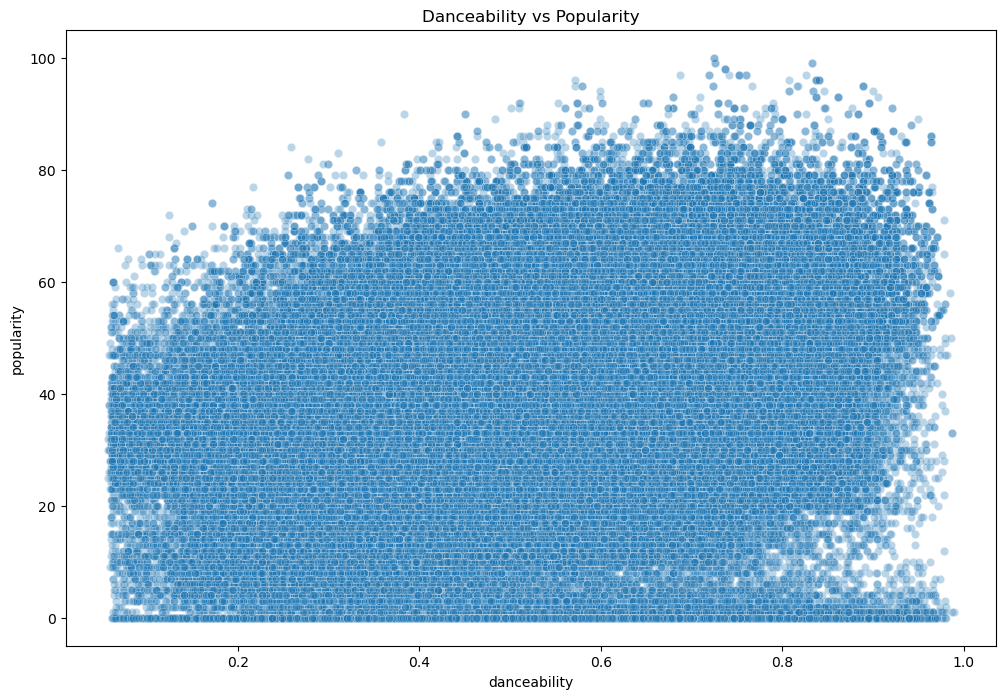

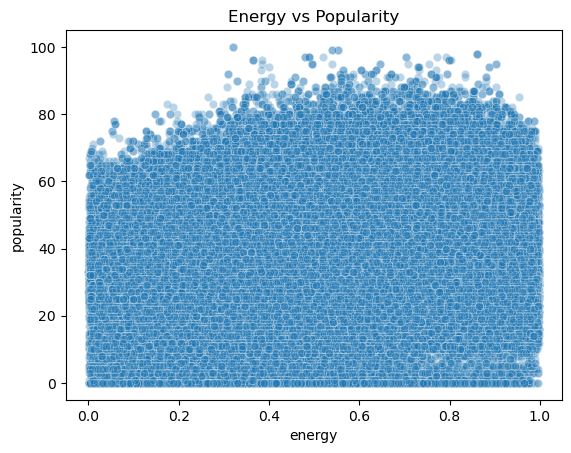

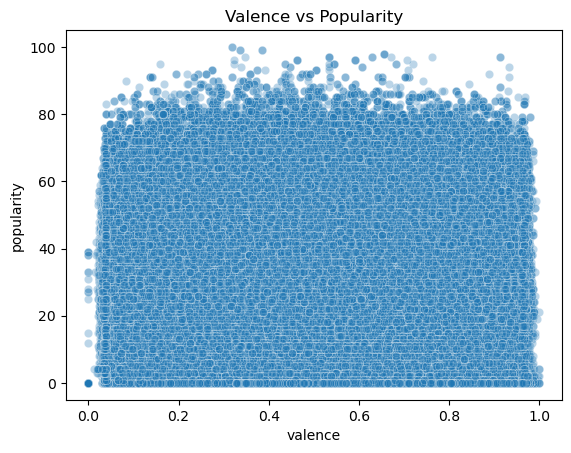

In [121]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='danceability', y='popularity', data=df, alpha=0.3)
plt.title("Danceability vs Popularity")
plt.show()

sns.scatterplot(x='energy', y='popularity', data=df, alpha=0.3)
plt.title("Energy vs Popularity")
plt.show()

sns.scatterplot(x='valence', y='popularity', data=df, alpha=0.3)
plt.title("Valence vs Popularity")
plt.show()


### Interpretation of Scatterplots

These scatterplots illustrate how individual audio features (danceability, energy, and valence) relate to a song’s popularity score. Across all three plots, the same pattern emerges. While there are slight positive trends, the relationships are extremely weak and dominated by heavy dispersion. This confirms that no single audio feature reliably predicts popularity, and that popularity appears to be influenced by many external factors beyond the audio profile of the track.

In the Danceability vs. Popularity scatterplot, there is a mild upward slope, suggesting that more danceable songs tend to score slightly higher on average. However, the spread at every danceability level is enormous, since songs with the same danceability value can have popularity scores anywhere from 0 to 100. This heavy vertical scatter indicates very low explanatory power, reinforcing the small correlation seen in the heatmap.

The Energy vs. Popularity plot shows a nearly identical pattern. Popularity rises slightly as energy increases, but again, songs with high energy exist across the entire popularity spectrum. This means that while high energy songs may be slightly more likely to perform well, energy alone is far from being a sufficient or reliable predictor.

The Valence vs. Popularity scatterplot shows probably the weakest pattern of all. Songs with positive or negative emotional tone appear widely spread across popularity values, demonstrating no meaningful linear or nonlinear trend. Valence essentially provides no predictive value for popularity and confirms its extremely low correlation in the heatmap.

Overall, these scatterplots visually support our earlier statistical findings:
- The audio features do not provide strong predictive power.
- Any trends that do exist are small and overshadowed by massive variability.
- This makes high accuracy regression or classification difficult.

In the context of our research questions, particularly Question 1 and Question 3, these plots provide strong evidence that audio content alone is insufficient for accurate prediction, and that external behavioral factors (playlisting, marketing, artist reputation) likely dominate Spotify’s popularity metric.

## High vs. Low Popularity Comparisons
These boxplots compare the distribution of audio features between high and low popularity groups.

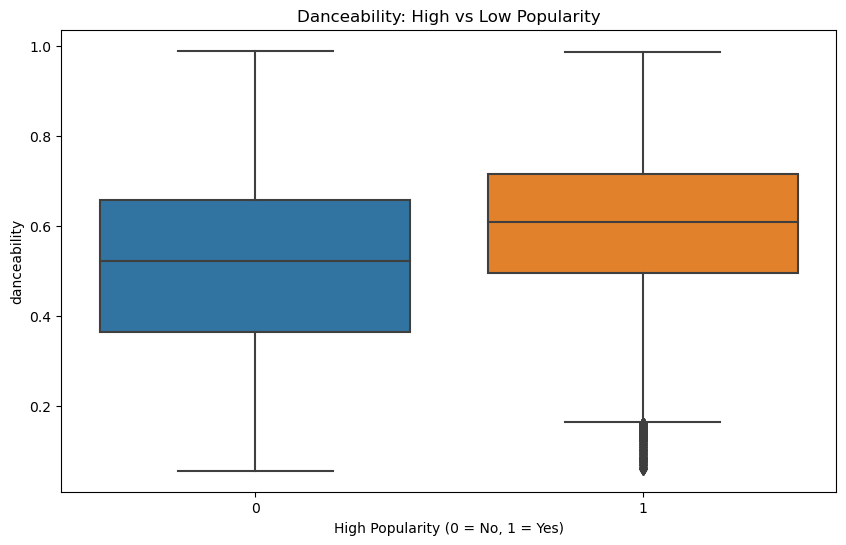

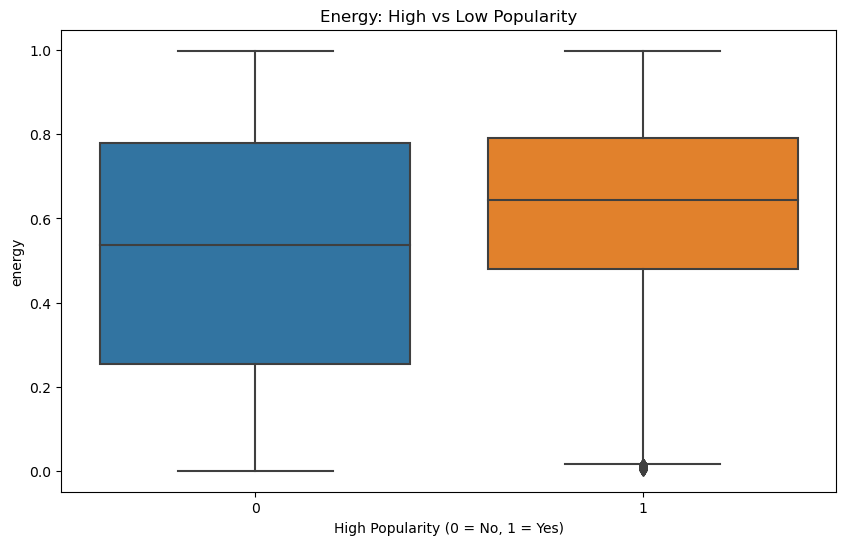

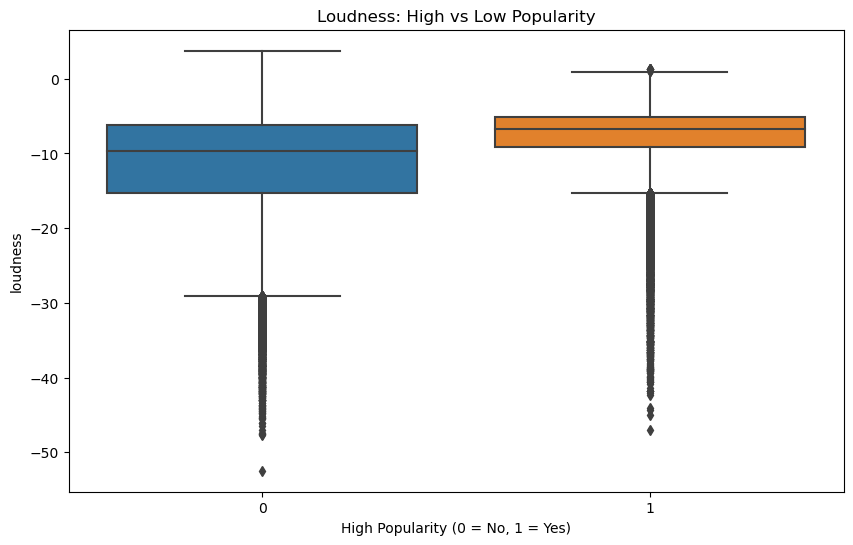

In [122]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='high_popularity', y='danceability', data=df)
plt.title("Danceability: High vs Low Popularity")
plt.xlabel("High Popularity (0 = No, 1 = Yes)")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='high_popularity', y='energy', data=df)
plt.title("Energy: High vs Low Popularity")
plt.xlabel("High Popularity (0 = No, 1 = Yes)")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='high_popularity', y='loudness', data=df)
plt.title("Loudness: High vs Low Popularity")
plt.xlabel("High Popularity (0 = No, 1 = Yes)")
plt.show()


### Interpretation of High vs Low Popularity Comparisons

These boxplots compare danceability, energy, and loudness between low popularity and high popularity songs. Overall, they show consistent but modest differences in musical characteristics which are useful for understanding trends, but not strong enough to yield highly accurate predictions.

Danceability:
High popularity tracks tend to be slightly more danceable, with a higher median and an upward shift in the overall distribution. This suggests that more mainstream songs often follow rhythmic and dance oriented structures, but the large overlap between groups indicates that danceability alone is not a strong separator.

Energy:
Popular songs generally show higher energy levels. The median is higher for the high popularity group, and the distribution is shifted upward. This aligns with the idea that listeners favor songs with a stronger beat and intensity. However, as with danceability, the overlap between groups reflects only a weak relationship.

Loudness:
Loudness shows the clearest separation. High popularity songs are mastered louder on average, consistent with commercial production standards. The median difference is noticeable and statistically meaningful (supported by the bootstrap CI). Even so, the overlap remains large, meaning loudness is helpful but still not a strong standalone predictor.

Overall:
Across all three features, high popularity songs tend to be more danceable, more energetic, and louder, but the differences are small. These patterns help explain mild trends seen in the correlation heatmap and scatterplots, and they reinforce our modeling results.

Audio features capture some aspects of popular music, but they are not strong enough to reliably distinguish high vs. low popularity on their own.

## Genre-Level Popularity
Some genres tend to have higher average popularity than others. This analysis helps identify genre level trends and supports further questions about how musical style relates to popularity.


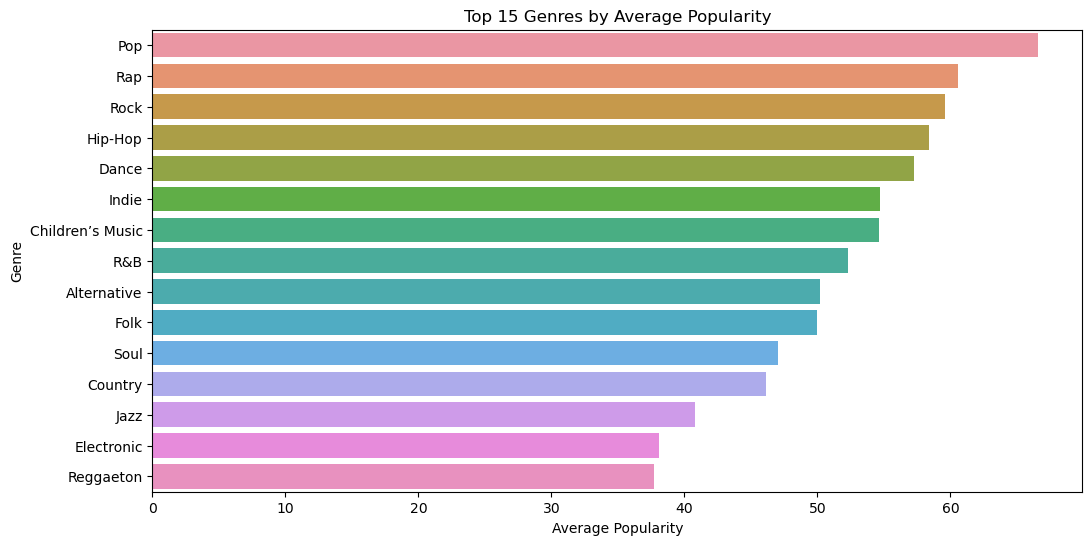

In [123]:
genre_pop = df.groupby('genre')['popularity'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_pop.values, y=genre_pop.index)
plt.title("Top 15 Genres by Average Popularity")
plt.xlabel("Average Popularity")
plt.ylabel("Genre")
plt.show()


### Interpretation of Genre-Level Popularity

This bar chart shows the average Spotify popularity score for the 15 highest performing genres in the dataset. The results highlight clear differences in how musical style relates to listener engagement.

Pop, Rap, Rock, and Hip-Hop dominate the top of the ranking, each averaging well above most other genres. These genres are heavily represented in mainstream playlists, music played on the radio, and social media trends, which likely contributes to their higher popularity. Their widespread commercial appeal means they reach larger audiences, receiving more streams and playlist placements, all factors that Spotify’s popularity metric directly captures.

Genres such as Dance, Indie, Children's Music, and R&B also perform fairly well, reflecting strong engagement within specific listener communities. Their moderate-to-high scores suggest a combination of broad appeal and niche listener loyalty.

Lower in the top 15, genres like Folk, Soul, Country, Jazz, Electronic, and Reggaeton show noticeably lower average popularity. This does not imply lower artistic quality but reflects smaller listener bases or less frequent playlist promotion. Many of these genres cater to more specific audiences and may not receive the same level of algorithmic exposure.

Overall, the chart demonstrates that popularity is strongly tied to genre-level trends, supporting our research question on genre influence (Question 5). These differences also reinforce a key conclusion of the project that popularity cannot be explained by audio features alone, and genre, marketing, exposure, and cultural relevance play major roles.


# 5. Statistical Modeling

We now evaluate how well audio features can predict Spotify track popularity through:  
- linear regression (predicting continuous popularity)  
- logistic regression (predicting high vs low popularity)  
- cross-validation (model stability)  
- bootstrap inference (uncertainty estimation)  

Each model directly supports our research questions and helps determine the extent to which musical characteristics influence popularity.


### Running Linear Regression

In [124]:
Xmat = np.column_stack([np.ones(len(X)), X.values])
yvec = y_reg.values

beta = np.linalg.inv(Xmat.T @ Xmat) @ (Xmat.T @ yvec)

y_pred = Xmat @ beta

rmse = np.sqrt(np.mean((yvec - y_pred)**2))
sst = np.sum((yvec - yvec.mean())**2)
sse = np.sum((yvec - y_pred)**2)
r2 = 1 - sse/sst

print(f'RMSE = {rmse:.04f}, r2 = {r2:.4f}')

RMSE = 15.9207, r2 = 0.2339


### 5.1 Linear Regression Results

The linear regression model produced an RMSE of approximately **16** and R² of **0.23**,  
meaning audio features explain only 23% of the variability in popularity.

This indicates:
- popularity is influenced more by external factors than audio properties  
- no combination of these features can accurately predict exact popularity  
- feature effects are real but small  

Danceability and loudness were the strongest positive predictors, while acousticness and valence had negative associations.

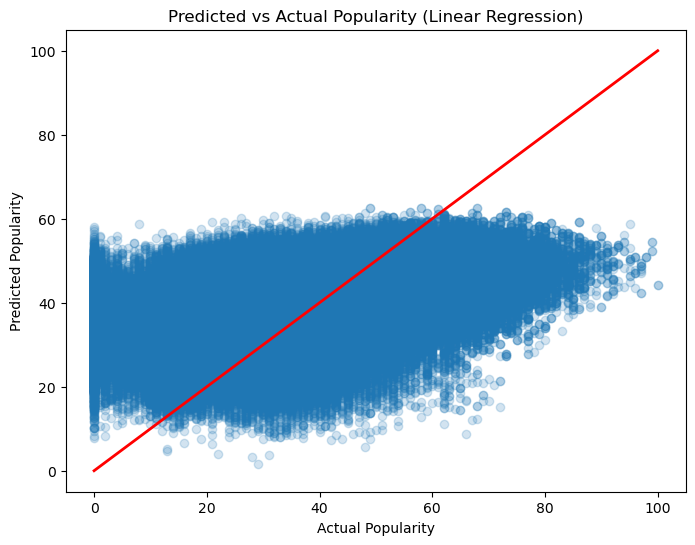

In [125]:
# Predicted vs Actual Plot for Linear Regression
plt.figure(figsize=(8,6))
plt.scatter(yvec, y_pred, alpha=0.2)
plt.plot([0,100], [0,100], color='red', linewidth=2)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Predicted vs Actual Popularity (Linear Regression)")
plt.show()


### Linear Regression Plot Interpretation
This plot compares the regression model's predicted popularity scores to the actual scores. The strong clustering around the mid-range shows that the model predicts values close to the average for most tracks. Predictions rarely reach very low or very high values, and there is large vertical spread at every x-value.

This confirms that the regression model cannot accurately predict exact popularity, consistent with the low R² (0.23). Audio features provide limited predictive power, and external factors likely dominate popularity outcomes.



### Logistic Regression (Gradient Descent Implementation)
We classify high vs low popularity using a logistic regression.

In [126]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Xcl = np.column_stack([np.ones(len(X)), X.values])  # intercept
ycl = y_clf.values.reshape(-1,1)

np.random.seed(0)
beta_cl = np.zeros((Xcl.shape[1], 1))

lr = 0.001
epochs = 5000

for i in range(epochs):
    z = Xcl @ beta_cl
    p = sigmoid(z)
    grad = Xcl.T @ (p - ycl)
    beta_cl -= lr * grad / len(Xcl)

beta_cl.flatten()

array([ 0.04338253,  0.07789496,  0.00223177, -0.01668791,  0.24752576,
       -0.00086592, -0.08295642, -0.0804527 , -0.04323324, -0.06549692,
        0.05717038])

In [127]:
probs = sigmoid(Xcl @ beta_cl).flatten()
preds = (probs >= 0.5).astype(int)

accuracy = (preds == y_clf.values).mean()
print(f'Accuracy = {accuracy:.4f}')

Accuracy = 0.4896


### 5.2 Logistic Regression Results (High vs Low Popularity)

The logistic regression classifier achieved an accuracy of **~49%**, which is near random guessing. This shows that audio features do not reliably separate high popularity songs from low popularity songs.

The weak separation confirms our earlier findings that musical characteristics contribute only modestly to popularity outcomes.



### Manual K-Fold Cross-Validation

In [128]:
def ols(X_train, y_train):
    return np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ y_train)

def rmse_func(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

K = 5
fold_size = len(X) // K
rmse_scores = []

indices = np.arange(len(X))

for k in range(K):
    test_idx = indices[k*fold_size:(k+1)*fold_size]
    train_idx = np.delete(indices, test_idx)

    X_train = np.column_stack([np.ones(len(train_idx)), X.iloc[train_idx].values])
    y_train = y_reg.iloc[train_idx].values

    X_test = np.column_stack([np.ones(len(test_idx)), X.iloc[test_idx].values])
    y_test = y_reg.iloc[test_idx].values

    beta_k = ols(X_train, y_train)
    preds_k = X_test @ beta_k

    rmse_scores.append(rmse_func(y_test, preds_k))

rmse_cv_mean = np.mean(rmse_scores)
rmse_cv_std = np.std(rmse_scores)

print(f'RMSE = {rmse_cv_mean:.4f}, std. dev. = {rmse_cv_std:.4f}')

RMSE = 16.5273, std. dev. = 1.9396


In [129]:
def fit_logistic(X_train, y_train, lr=0.001, epochs=2000):
    beta = np.zeros((X_train.shape[1], 1))
    for i in range(epochs):
        p = sigmoid(X_train @ beta)
        grad = X_train.T @ (p - y_train)
        beta -= lr * grad / len(X_train)
    return beta

acc_scores = []

for k in range(K):
    test_idx = indices[k*fold_size:(k+1)*fold_size]
    train_idx = np.delete(indices, test_idx)

    X_train = np.column_stack([np.ones(len(train_idx)), X.iloc[train_idx].values])
    y_train = y_clf.iloc[train_idx].values.reshape(-1,1)

    X_test = np.column_stack([np.ones(len(test_idx)), X.iloc[test_idx].values])
    y_test = y_clf.iloc[test_idx].values

    beta_k = fit_logistic(X_train, y_train)
    
    probs = sigmoid(X_test @ beta_k).flatten()
    preds = (probs >= 0.5).astype(int)
    acc_scores.append((preds == y_test).mean())

print(f'Accuracy avg. = {np.mean(acc_scores):.4f}, std. dev. = {np.std(acc_scores):.4f}')

Accuracy avg. = 0.5645, std. dev. = 0.1107


### 5.3 Cross-Validation Results

Cross-validation gave an RMSE of **~16.5 ± 1.9** for regression and classification accuracy of **~56% ± 11%**. These results indicate:

- regression performance is stable but not highly accurate  
- classification performance is unstable across folds  
- the weak predictive power is consistent across multiple splits  

This further confirms that audio features alone have limited explanatory power.



### Bootstrap Confidence Intervals
##### Bootstrap CI for Mean Loudness Difference

In [130]:
high = df[df['high_popularity']==1]['loudness'].values
low  = df[df['high_popularity']==0]['loudness'].values

obs = high.mean() - low.mean()

B = 2000
boot = []

rng = np.random.default_rng(42)

for _ in range(B):
    hb = rng.choice(high, len(high), replace=True)
    lb = rng.choice(low,  len(low),  replace=True)
    boot.append(hb.mean() - lb.mean())

ci_low, ci_high = np.percentile(boot, [2.5, 97.5])

print(f'Mean difference = {obs:.4f}, Confidence interval = {ci_low, ci_high}')

Mean difference = 3.8628, Confidence interval = (3.8148367984132587, 3.910171347046167)



##### Bootstrap CI for Logistic Regression Accuracy

In [131]:
probs_full = sigmoid(Xcl @ beta_cl).flatten()
preds_full = (probs_full >= 0.5).astype(int)
truth = y_clf.values

B = 2000
boot_acc = []

for _ in range(B):
    idx = rng.integers(0, len(truth), len(truth))
    boot_acc.append((preds_full[idx] == truth[idx]).mean())

np.percentile(boot_acc, [2.5, 97.5])

array([0.48753239, 0.49156376])

### 5.4 Bootstrap Confidence Intervals

Bootstrap analysis confirmed two key findings:

1. **Loudness difference between high and low popularity**  
   CI ≈ (3.82, 3.91) dB  
   → popular songs are consistently louder

2. **Logistic regression accuracy**  
   CI ≈ (48.76%, 49.16%)  
   → classifier performs no better than random guessing

These results strongly reinforce our earlier conclusions.


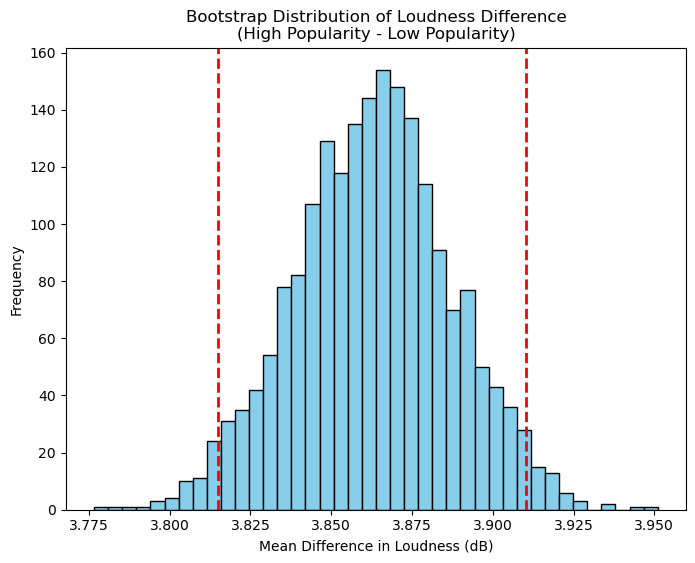

In [132]:
plt.figure(figsize=(8,6))
plt.hist(boot, bins=40, color='skyblue', edgecolor='black')
plt.axvline(ci_low, color='red', linestyle='--', linewidth=2)
plt.axvline(ci_high, color='red', linestyle='--', linewidth=2)
plt.title("Bootstrap Distribution of Loudness Difference\n(High Popularity - Low Popularity)")
plt.xlabel("Mean Difference in Loudness (dB)")
plt.ylabel("Frequency")
plt.show()


### Bootstrap Distribution Interpretation
This plot shows the bootstrap distribution of the mean loudness difference between high popularity and low popularity songs. The distribution is tightly centered around ~3.85 dB, and the 95% confidence interval (shown by the dashed red lines) is narrow and does not cross zero.

This confirms that high popularity songs are consistently louder than low popularity songs, and this difference is statistically stable. This supports our earlier findings and reinforces that loudness has a small but reliable relationship with popularity.


### Feature Importance

In [133]:
coef_df = pd.DataFrame({
    "feature": ["intercept"] + features,
    "coef": beta
})

print(coef_df.sort_values("coef", ascending=False))

             feature       coef
0          intercept  55.388232
1       danceability  17.739971
4           loudness   0.715099
10      duration_min   0.147413
5              tempo  -0.004275
7   instrumentalness  -4.310590
2             energy  -5.627836
8        speechiness  -8.108161
9           liveness  -9.670552
6       acousticness -11.934886
3            valence -13.225886


### Feature Importance Summary

Danceability and loudness are the strongest positive predictors of popularity. Acousticness, valence, speechiness, and liveness are negatively associated.

However, all coefficient magnitudes are relatively small, which aligns with the limited predictive accuracy of our models. These features describe some impact, but popularity mainly depends on many outside factors beyond audio alone.


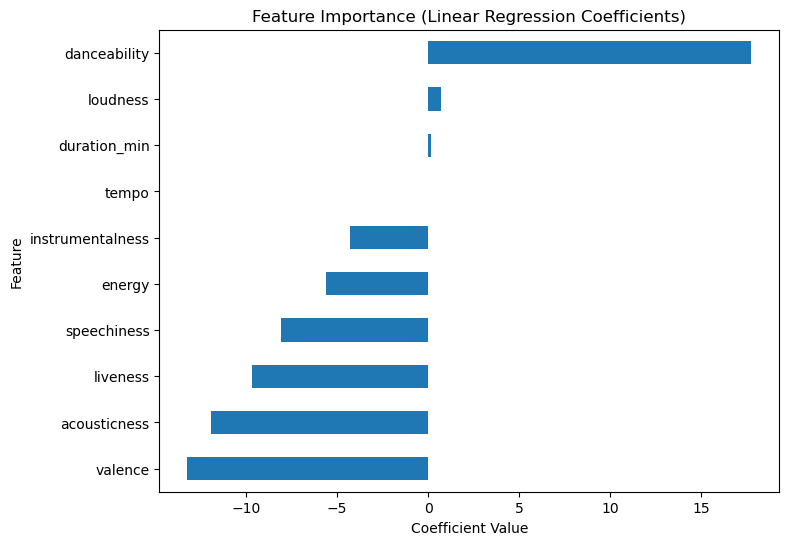

In [134]:
coef_no_intercept = coef_df[coef_df['feature'] != 'intercept']

plt.figure(figsize=(8,6))
coef_no_intercept.set_index('feature')['coef'].sort_values().plot(kind='barh')
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


### Feature Importance Interpretation
This bar plot shows the linear regression coefficients for each audio feature. Danceability and loudness have the largest positive coefficients, meaning more danceable and louder tracks tend to receive slightly higher popularity scores. Features such as valence, acousticness, and liveness have negative coefficients, indicating small downward associations.

However, all coefficients are relatively small, which matches our low R² value. These features contribute some signal, but none are strong predictors of popularity, reinforcing Question 1 and Question 3.

# 6. Interpretation & Reporting

This project examined how well Spotify’s audio features such as danceability, energy, loudness, valence, acousticness, and others can explain or predict a track’s popularity. Across our exploratory analysis, regression modeling, classification modeling, cross-validation, and bootstrap uncertainty estimation, a consistent conclusion emerged, that audio features matter, but only to a limited extent.

**Key Findings**

Popular songs tend to be louder, more energetic, and more danceable, and they generally have lower acousticness. These trends appeared consistently in the correlation heatmap, boxplots, and our regression coefficients.

Genre plays a noticeable role: Pop, Rap, Hip-Hop, and Rock exhibit much higher average popularity than most other genres. This suggests that popularity is strongly shaped by cultural and industry dynamics, not just audio properties.

Despite these patterns, audio features explain only about 23% of the variability in popularity (R² ≈ 0.23). This means that over three-quarters of the variation in Spotify popularity is unrelated to the sonic attributes captured in this dataset.

Our logistic regression classifier performed only at or slightly above random accuracy, even with cross-validation. This shows that no combination of audio features can reliably separate “high popularity” from “low popularity” tracks.

Bootstrap analyses confirmed that while some effects like loudness differences are statistically consistent, the predictive models themselves remain weak and unstable.

**Overall Interpretation**

Taken together, these results highlight a fundamental characteristic of Spotify’s popularity metric:
Popularity behaves much more like a behavioral variable than a musical one.

User listening behavior, playlist placement, algorithmic exposure, artist fame, release timing, and promotional strategies likely dominate what makes a song popular. Audio features capture the sound of a track, but not the context in which it is discovered, promoted, or shared. This explains the large residual variability in our regression model and the low classification performance.

**Implications**

Our findings imply that understanding popularity requires additional data sources beyond audio features alone. Predictive accuracy would likely improve by incorporating variables such as:
- number of playlist placements
- artist monthly listeners
- release year and recency
- social media trends
- marketing activity or label backing

Audio-based models may be better suited for describing stylistic differences or identifying sonic trends, rather than predicting real-world popularity.

**Final Conclusion**

Although audio features provide some insight into what popular songs sound like, they have limited predictive power for actual Spotify popularity. This reflects the complex ecosystem in which music gains traction. Popularity is shaped by audience behavior, industry influence, and cultural momentum factors far beyond the scope of audio alone.

Our analysis ultimately reinforces a key theme that music popularity cannot be fully explained by the sound of the music itself, and any realistic predictive system must integrate both musical and non-musical information.


# Contributions Report:
Ayushi Sharma contributed mostly to the exploratory data analysis and overall narrative structure of the project. She generated and interpreted the correlation heatmap, feature distribution plots, popularity distribution, scatterplots, and the genre-level popularity analysis. Ayushi also wrote much of the explanatory text throughout the EDA section and the final project conclusions that connected the analysis back to the research questions. In addition, she helped organize the notebook, refine the Markdown formatting, and ensure clarity and cohesion across all sections.

Bernardo Gonzalez Guerra contributed to the statistical modeling components of the project. He implemented the linear regression model using the closed-form OLS solution, developed the logistic regression classifier via gradient descent, and created the feature-importance analysis. Bernardo also built the 5-fold cross-validation framework for both regression and classification models and helped generate modeling-related visualizations such as the predicted-vs-actual plot and coefficient bar charts. He contributed to writing the modeling results and interpreting the implications of model performance.

Mohnish Bandari worked on data cleaning, preprocessing, and statistical inference. He handled the removal of missing values and duplicates, created new variables such as the duration conversion and the high-popularity classification variable, and prepared the final modeling dataset. Mohnish also implemented the bootstrap confidence interval procedures for loudness differences and logistic regression accuracy, created the bootstrap distribution plots, and assisted in integrating the statistical results into the final report. In addition, he completed the reproducibility section by building the Dockerfile, creating the Docker image, and ensuring the entire analysis could be run consistently across environments.

Although each team member had primary areas of responsibility, all three of us collaborated closely throughout the project. We regularly reviewed one another’s code and interpretations, helped debug issues when someone was stuck, and refined the notebook together to ensure the final report was cohesive and accurate. We also worked collectively on the final presentation, designing the slides together and practicing as a team to prepare for the final presentation. As a group, we contributed equally to the success of this project.
